In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import numpy as np

# interactive graphs on jupyter notebook
import mpld3

# 1. Data Extraction

In [2]:
filename = '../resources/data/4D_result_2018-01-01_2018-12-31.csv'
raw_data = pd.read_csv(filename, sep=';', dtype={'number': str})
# raw_data.info()

# 2. Data Transformation

In [3]:
transform_data = raw_data.copy()
transform_data.loc[transform_data['company_code'] == 'DMC', 'company_code'] = 'Da Ma Cai'
transform_data.loc[transform_data['company_code'] == 'MAG', 'company_code'] = 'Magnum'
transform_data.loc[transform_data['company_code'] == 'ST', 'company_code'] = 'Sports Toto'

transform_data.loc[transform_data['category'] == 'FST', 'category'] = '1st'
transform_data.loc[transform_data['category'] == 'SCD', 'category'] = '2nd'
transform_data.loc[transform_data['category'] == 'TRD', 'category'] = '3rd'
transform_data.loc[transform_data['category'] == 'SP', 'category'] = 'Special'
transform_data.loc[transform_data['category'] == 'CONS', 'category'] = 'Consolation'

# 3. Data Filtering

In [4]:
date_from = transform_data.min()['draw_date']
date_to = transform_data.max()['draw_date']

# date_from = '2018-01-01'
# date_to = '2018-01-31'

categories = ['1st', '2nd', '3rd', 'Special', 'Consolation']
price_count = sum(list(map(lambda x:
                           (x == '1st' or x == '2nd' or x == '3rd') and 1 or
                           (x == 'Special' or x == 'Consolation') and 10 or 0, categories
                          )))

company_code = 'Magnum'
data = transform_data[(transform_data['number'] != '----') &
                      (transform_data['company_code'] == company_code) &
                      (transform_data['draw_date'] >= date_from) &
                      (transform_data['draw_date'] <= date_to) &
                      (transform_data['category'].isin(categories))]
data = data.sort_values(by=['draw_date', 'company_code', 'category', 'position'])

# 4. Pre-Processing
### 4.1 Input & Target Preparation

In [5]:
period_arr = []
period_dict = data.groupby('draw_date').groups
for k in period_dict.keys():
    period_arr.append([data.loc[i]['number'] for i in period_dict.get(k)])

In [6]:
max_value = 9999
input_data = []
target_data = []

period_count = 2
for i, arr in enumerate(period_arr): 
    if i == len(period_arr) - period_count:
        break
    
    tmp_arr = []
    for n in range(period_count):
        tmp_arr.append(
            list(filter(lambda x: x[0] == i+n, enumerate(period_arr)))[0][1]
        )
    
    # Data Normalization
    input_data.append(
        [[float(n) / max_value for n in tmp_arr2] for tmp_arr2 in tmp_arr]
    )
    target_data.append(
        [float(n) / max_value for n in period_arr[i + period_count]]
    )

In [7]:
input_data = np.array(input_data, dtype=float)
target_data = np.array(target_data, dtype=float)

print('input_data.shape\t', input_data.shape)
print('target_data.shape\t', target_data.shape)

input_data.shape	 (179, 2, 23)
target_data.shape	 (179, 23)


### 4.2 Train & Test Preparation

In [8]:
x_train, x_test, y_train, y_test = train_test_split(input_data, target_data, test_size=0.2, random_state=4)

print('x_train.shape', x_train.shape)
print('x_test.shape', x_test.shape)

x_train.shape (143, 2, 23)
x_test.shape (36, 2, 23)


# 5. Linear Regression

In [13]:
reshape_size = price_count * period_count

reg = linear_model.LinearRegression()
reg.fit(x_train.reshape(-1, reshape_size), y_train)
results = reg.predict(x_test.reshape(-1, reshape_size))

print('results.shape', results.shape)
print('y_test.shape', y_test.shape)

results.shape (36, 23)
y_test.shape (36, 23)


# 6. Result Visualization

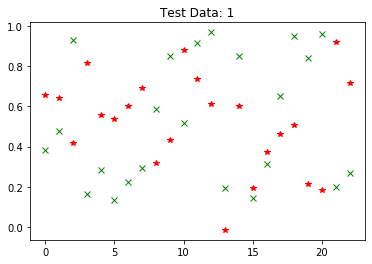

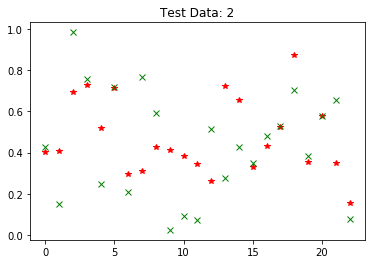

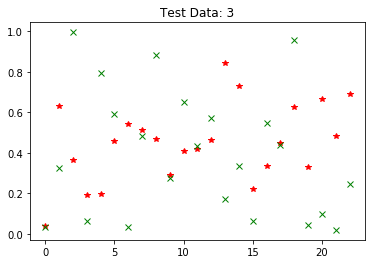

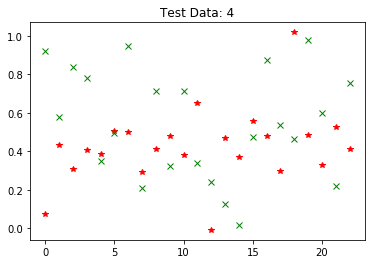

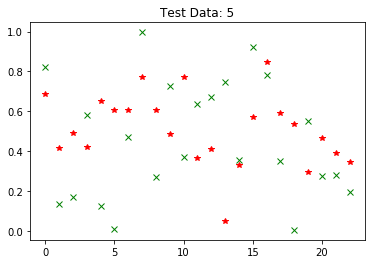

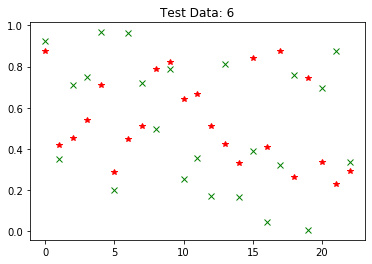

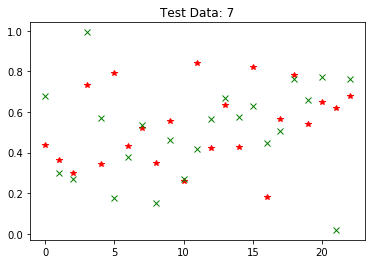

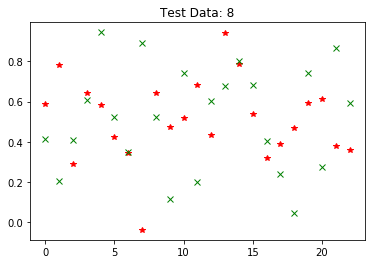

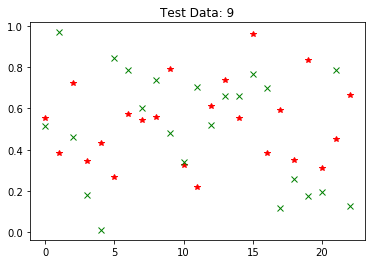

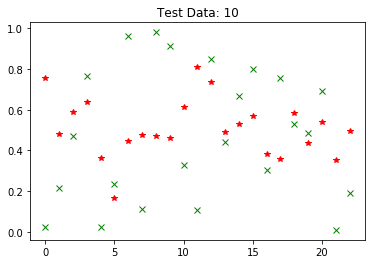

In [15]:
mpld3.enable_notebook()
plt.rcParams['figure.figsize'] = [6, 4]

for i, arr in enumerate(y_test[:10]):
    plt.title(f'Test Data: {i+1}')
    plt.plot(range(results.shape[1]), results[i], c='r', marker='*', ls='none', label='Predicted')
    plt.plot(range(results.shape[1]), arr, c='g', marker='x', ls='none', label='Expected')
    plt.show()